In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [21]:
plt.style.use('default')

In [22]:
# Load the dataset
# Assuming 'sonar.mines' and 'sonar.rocks' are combined into a single file 'sonar.csv'
data_path = 'sonar.csv'  # Update this to your actual file path
data = pd.read_csv(data_path, header=None)
print(len(data))

208


In [23]:
# Add column names
num_features = 60
data.columns = [f'Feature_{i}' for i in range(1, num_features + 1)] + ['Label']

In [24]:
# Encode labels ('R' -> 0, 'M' -> 1)
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

In [25]:
# Split data into features and labels
X = data.iloc[:, :-1].values
y = data['Label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [27]:
# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [28]:
# Define the Neural Network
class SonarNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SonarNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [29]:
# Model parameters
input_size = num_features
hidden_size = 32
output_size = 1
model = SonarNN(input_size, hidden_size, output_size)

In [30]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
# Training loop
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch [1/50], Train Loss: 0.6947, Test Loss: 0.6879
Epoch [2/50], Train Loss: 0.6795, Test Loss: 0.6811
Epoch [3/50], Train Loss: 0.6740, Test Loss: 0.6764
Epoch [4/50], Train Loss: 0.6695, Test Loss: 0.6716
Epoch [5/50], Train Loss: 0.6650, Test Loss: 0.6661
Epoch [6/50], Train Loss: 0.6561, Test Loss: 0.6609
Epoch [7/50], Train Loss: 0.6538, Test Loss: 0.6546
Epoch [8/50], Train Loss: 0.6444, Test Loss: 0.6498
Epoch [9/50], Train Loss: 0.6331, Test Loss: 0.6424
Epoch [10/50], Train Loss: 0.6259, Test Loss: 0.6343
Epoch [11/50], Train Loss: 0.6197, Test Loss: 0.6275
Epoch [12/50], Train Loss: 0.6000, Test Loss: 0.6213
Epoch [13/50], Train Loss: 0.5995, Test Loss: 0.6138
Epoch [14/50], Train Loss: 0.5855, Test Loss: 0.6065
Epoch [15/50], Train Loss: 0.5875, Test Loss: 0.5988
Epoch [16/50], Train Loss: 0.5840, Test Loss: 0.5911
Epoch [17/50], Train Loss: 0.5667, Test Loss: 0.5845
Epoch [18/50], Train Loss: 0.5623, Test Loss: 0.5771
Epoch [19/50], Train Loss: 0.5480, Test Loss: 0.5703
Ep

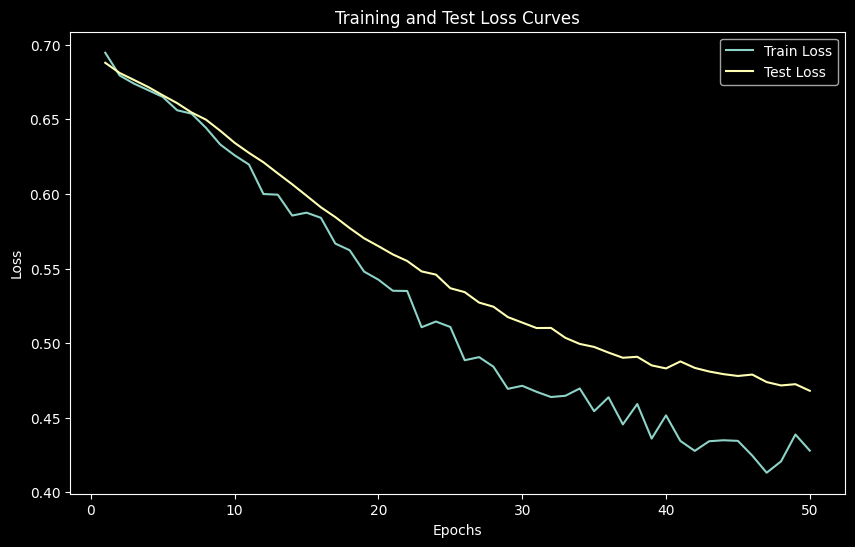

In [32]:
# Plot loss curves
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.savefig('loss_curves.png')
plt.show()

In [33]:
# Save the model
torch.save(model.state_dict(), 'sonar_nn_model.pth')

In [34]:
# Evaluation Metrics
def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            predictions = (outputs >= 0.5).float()
            y_true.extend(y_batch.numpy())
            y_pred.extend(predictions.numpy())
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = evaluate_model(model, test_loader)

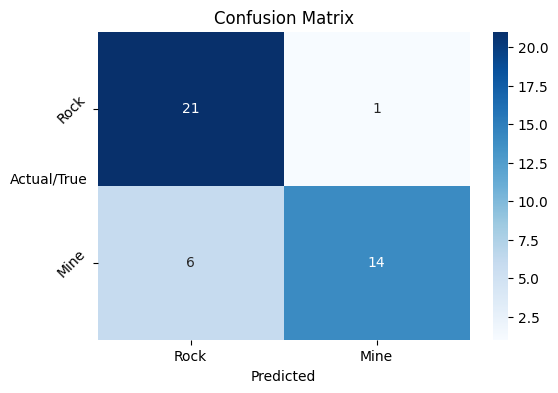

In [42]:
plt.style.use('default')
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Rock', 'Mine'], yticklabels=['Rock', 'Mine'])
plt.xlabel('Predicted')
plt.ylabel('Actual/True', rotation = 'horizontal')
plt.yticks(rotation=45) 
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [36]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=['Rock', 'Mine']))

              precision    recall  f1-score   support

        Rock       0.78      0.95      0.86        22
        Mine       0.93      0.70      0.80        20

    accuracy                           0.83        42
   macro avg       0.86      0.83      0.83        42
weighted avg       0.85      0.83      0.83        42



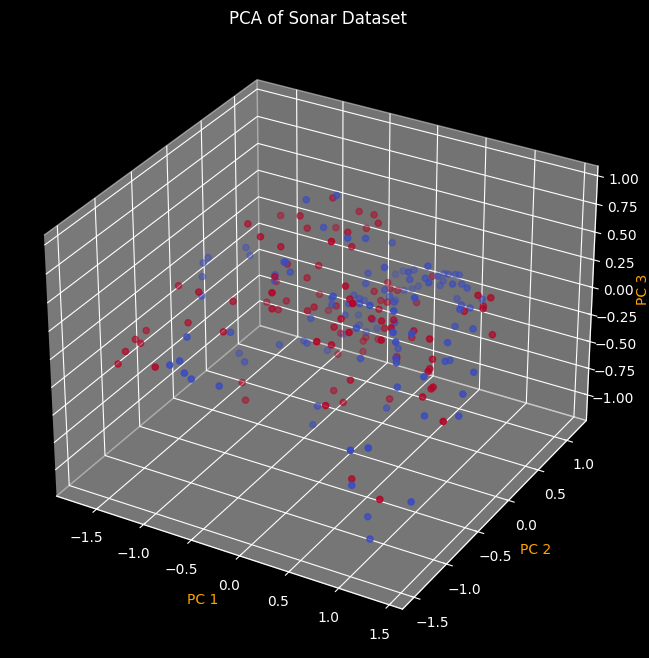

In [37]:
# Visualize train-test split (scatter plot after dimensionality reduction like PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
#plt.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='coolwarm', projection='3d')
#plt.title('PCA of Sonar Dataset')
#plt.show()
plt.style.use('dark_background')
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('black')
ax = fig.add_subplot(projection='3d')
ax.set_facecolor('black')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], cmap = 'coolwarm', c=y)
ax.set_xlabel('PC 1', color = 'orange')
ax.set_ylabel('PC 2', color = 'orange')
ax.set_zlabel('PC 3', color = 'orange')
ax.zaxis.labelpad=1.5
ax.zaxis.label.set_rotation(90)
plt.title('PCA of Sonar Dataset')
plt.savefig('pca.svg', format='svg')


In [38]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']